<a href="https://colab.research.google.com/github/GeeK1224/cau_ml_project/blob/main/cau_ml_project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision.transforms import transforms
import torchvision

In [184]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [4]:
!wget https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_test_features_public.csv
!wget https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_train_data_public.csv
!wget https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/sample_submission.csv

--2023-12-20 15:46:39--  https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_test_features_public.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216168 (211K) [text/plain]
Saving to: ‘kaggle_test_features_public.csv’

kaggle_test_feature 100%[===================>] 211.10K  --.-KB/s    in 0.03s   

2023-12-20 15:46:39 (5.97 MB/s) - ‘kaggle_test_features_public.csv’ saved [216168/216168]

--2023-12-20 15:46:39--  https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_train_data_public.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request 

## ml model team ATES

In [207]:
# Data Collection
test_data = pd.read_csv("kaggle_test_features_public.csv")
train_data = pd.read_csv("kaggle_train_data_public.csv")
sample = pd.read_csv("sample_submission.csv")

In [186]:
def one_hot_encode_column(dataframe, column_name):
    """
    Perform one-hot encoding on a specific column of a DataFrame.

    Parameters:
    - dataframe: pandas DataFrame
    - column_name: str, the name of the column to one-hot encode

    Returns:
    - dataframe_encoded: pandas DataFrame, the DataFrame with the specified column one-hot encoded
    """

    # Make a copy of the DataFrame to avoid modifying the original
    dataframe_copy = dataframe.copy()

    # Perform one-hot encoding
    dataframe_encoded = pd.get_dummies(dataframe_copy, columns=[column_name], prefix=column_name)

    return dataframe_encoded

In [187]:
def zeros_and_ones(dataframe, column_name):

  # Make a copy of the DataFrame to avoid modifying the original
  dataframe_copy = dataframe.copy()

  # Perform turning values to zeros and ones
  dataframe_copy[column_name].replace('Yes', 1, inplace=True)
  dataframe_copy[column_name].replace('No', 0, inplace=True)

  return dataframe_copy

In [188]:
# Feature engineering Test Data
drop_columns = ["CustomerID", "Count", "Country", "State", "City", "Zip Code", "Lat Long", "Latitude", "Longitude"]
category_yes_no = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
categories_many = ['Gender', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']

test_data = test_data.copy()
for category in category_yes_no:
  test_data = zeros_and_ones(test_data, category)


for category in categories_many:
  test_data = one_hot_encode_column(test_data, category)

encode_test = test_data.drop(drop_columns, axis=1)
encode_test


,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Gender_Female,Gender_Male,Multiple Lines_No,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,1,0,51,0,1,30.05,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,0,1,0,49,1,1,99.05,0,1,0,...,0,0,1,1,0,0,1,0,0,0
2,0,0,0,60,1,1,116.60,0,1,0,...,0,0,1,0,1,0,0,1,0,0
3,0,1,0,45,1,1,54.15,1,0,1,...,1,0,0,0,1,0,0,1,0,0
4,0,1,1,31,1,0,25.75,0,1,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0,1,0,34,1,0,62.65,1,0,0,...,1,0,0,1,0,0,0,0,1,0
982,0,0,1,9,1,0,55.35,0,1,1,...,1,0,0,1,0,0,0,0,1,0
983,1,1,0,23,1,1,95.10,1,0,1,...,0,0,1,1,0,0,0,0,1,0
984,0,0,0,21,1,1,99.15,1,0,1,...,0,0,1,1,0,0,1,0,0,0


In [189]:
# Feature engineering Train Data
drop_columns = ["CustomerID", "Count", "Country", "State", "City", "Zip Code", "Lat Long", "Latitude", "Longitude"]
category_yes_no = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
categories_many = ['Gender', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']

train_data = train_data.copy()
for category in category_yes_no:
  train_data = zeros_and_ones(train_data, category)


for category in categories_many:
  train_data = one_hot_encode_column(train_data, category)

encode_train = train_data.drop(drop_columns, axis=1)
encode_train

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Churn Score,Churn Value,CLTV,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,0,1,21,1,0,80.35,62,0,4579,...,1,0,0,1,0,0,0,0,1,0
1,0,0,1,9,1,0,93.00,40,0,2267,...,0,0,1,1,0,0,1,0,0,0
2,0,1,0,69,1,1,106.40,26,0,4328,...,0,0,1,0,1,0,0,1,0,0
3,0,0,0,9,1,1,75.85,70,0,5212,...,1,0,0,1,0,0,0,0,1,0
4,0,1,0,5,1,0,20.10,42,0,2894,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,0,0,0,3,1,0,55.35,65,1,5787,...,1,0,0,1,0,0,0,0,1,0
3940,0,1,0,24,1,1,93.00,29,0,5886,...,0,0,1,1,0,0,0,0,1,0
3941,0,0,0,1,1,1,45.70,95,1,2295,...,1,0,0,1,0,0,0,0,0,1
3942,1,1,0,47,1,1,67.45,67,0,4074,...,1,0,0,1,0,0,0,1,0,0


In [190]:
# deviding data to X and y
targets = ['Churn Score', 'Churn Value' ,'CLTV', 'Churn Reason']

X = encode_train.drop(targets, axis=1)
y = encode_train['Churn Value']

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# SMOTE

In [192]:
from imblearn.over_sampling import SMOTE

In [193]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_smote, y_smote = smote.fit_resample(X, y)

In [196]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())

print("Class distribution before SMOTE:")
print(y.value_counts())

print("\nClass distribution after SMOTE:")
print(y_smote.value_counts())

Class distribution before SMOTE:
0    2899
1    1045
Name: Churn Value, dtype: int64

Class distribution after SMOTE:
0    2899
1    2899
Name: Churn Value, dtype: int64


# Models

In [197]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Ensemble 1
- XGBoost
- AdaBoost
- Neural Network

In [141]:
import tensorflow as tf

In [142]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [143]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(40,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return model, history

32 nodes, dropout 0.2, lr 0.005, batch size 32


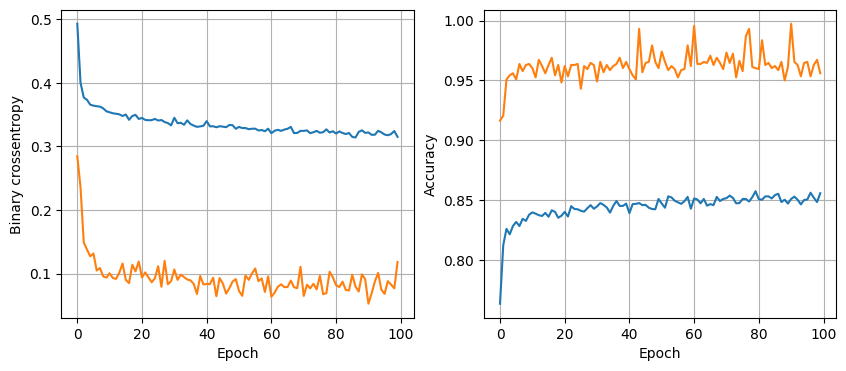

41/41 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.7320


In [144]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
num_nodes = 32
dropout_prob = 0.2
lr = 0.005
batch_size = 32

print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
nn_model, history = train_model(X_train_resampled, y_train_resampled, num_nodes, dropout_prob, lr, batch_size, epochs)
plot_history(history)
val_loss = nn_model.evaluate(X_test, y_test)[0]
if val_loss < least_val_loss:
  least_val_loss = val_loss
  least_loss_model = nn_model

In [145]:
nn_model.fit(X_smote, y_smote, batch_size=32, epochs=100)

Epoch 1/100
182/182 [==============================] - 1s 2ms/step - loss: 1.0348 - accuracy: 0.7118
Epoch 2/100
182/182 [==============================] - 0s 2ms/step - loss: 0.4838 - accuracy: 0.7618
Epoch 3/100
182/182 [==============================] - 0s 2ms/step - loss: 0.4521 - accuracy: 0.7870
Epoch 4/100
182/182 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.8061
Epoch 5/100
182/182 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.8201
Epoch 6/100
182/182 [==============================] - 1s 3ms/step - loss: 0.3842 - accuracy: 0.8234
Epoch 7/100
182/182 [==============================] - 0s 3ms/step - loss: 0.3658 - accuracy: 0.8330
Epoch 8/100
182/182 [==============================] - 1s 3ms/step - loss: 0.3580 - accuracy: 0.8394
Epoch 9/100
182/182 [==============================] - 1s 3ms/step - loss: 0.3491 - accuracy: 0.8386
Epoch 10/100
182/182 [==============================] - 1s 3ms/step - loss: 0.3521 - accura

In [ ]:
nn_predict_proba = nn_model.predict(encode_test)

In [ ]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': nn_predict_proba[:, 0]})
submission_df.to_csv('pred.csv', index=False)

In [146]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder

In [147]:
class NeuralNetworkWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        # Assuming your model outputs probabilities
        prob = self.model.predict(X)
        print(prob.shape)
        return prob[:, 0]

    def predict_proba(self, X):
        # Assuming your model outputs probabilities
        prob = self.model.predict(X)
        print(prob.shape)
        return prob[:, 0]

In [148]:
class ClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self.model.fit(X, y)

    def predict_proba(self, X):
        # Assuming your model outputs probabilities
        return self.model.predict_proba(X).flatten()[986:]

In [149]:
xgb_model = ClassifierWrapper(XGBClassifier())
ada_model = ClassifierWrapper(AdaBoostClassifier())
logreg_model = ClassifierWrapper(LogisticRegression())
nn_model = NeuralNetworkWrapper(nn_model)

ensemble_model1 = VotingClassifier(
    estimators=[
      ('xgb', xgb_model),
      ('ada', ada_model),
      ('lr', logreg_model),
      ('nn', nn_model),
    ], voting='soft'
)

In [150]:
ensemble_model1.fit(X_smote, y_smote)
ensemble_model1_predict_proba = ensemble_model1.predict_proba(encode_test)

31/31 [==============================] - 0s 1ms/step
(986, 1)


In [ ]:
roc_auc = roc_auc_score(y_test, ensemble_model1_predict_proba[:, 1])
roc_auc

In [151]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': ensemble_model1_predict_proba})
submission_df.to_csv('pred.csv', index=False)

# Ensemble 2
- XGBoost
- AdaBoost

In [159]:
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.05)
ada_model = AdaBoostClassifier(n_estimators=400, learning_rate=0.05)

ensemble_model2 = VotingClassifier(
    estimators=[
      ('xgb', xgb_model),
      ('ada', ada_model),
    ], voting='soft'
)

In [160]:
ensemble_model2.fit(X_smote, y_smote)
ensemble_model2_predict_proba = ensemble_model2.predict_proba(encode_test)

In [ ]:
roc_auc = roc_auc_score(y_test, ensemble_model2_predict_proba[:, 1])
roc_auc

In [161]:
ensemble_model2_predict_proba

array([[0.45950561, 0.54049439],
       [0.35782548, 0.64217452],
       [0.64842391, 0.35157608],
       ...,
       [0.47308909, 0.52691091],
       [0.43698858, 0.56301142],
       [0.67582466, 0.32417533]])

In [162]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': ensemble_model2_predict_proba[:, 1]})
submission_df.to_csv('pred.csv', index=False)

# XGBoost

In [169]:
# Create an XGBoost classifier
xgboost_model = XGBClassifier(n_estimators=400, learning_rate=0.05)

# Fit the model on the resampled training data
xgboost_model.fit(X_smote, y_smote)

# Make predictions on the test set
xgboost_predict_proba = xgboost_model.predict_proba(encode_test)

In [ ]:
roc_auc = roc_auc_score(y_test, xgboost_predict_proba[:, 1])
roc_auc

In [166]:
X_resampled_combined = np.concatenate((X_train_resampled, X_test), axis=0)
y_resampled_combined = np.concatenate((y_train_resampled, y_test), axis=0)

# Perform k-fold cross-validation (let's say k=5)
k = 5
cv_scores = cross_val_score(xgboost_model, X_resampled_combined, y_resampled_combined, cv=k, scoring='accuracy')

# Display cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')

Cross-Validation Scores: [0.75862069 0.84084372 0.90699904 0.9050815  0.77277085]
Mean Accuracy: 0.8369


In [170]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': xgboost_predict_proba[:, 1]})
submission_df.to_csv('pred.csv', index=False)

# AdaBoost
Based on Decision Trees and Random Forests ideas.

В отичии от RF, adaboost использует stumps а не полные деревья. Мы также строим огромную кучу недодеревьев стампов и устраиваем голосование. Но в отличии от rf порядок этих стампов имеет значение и каждый стамп имеет разную силу голоса при голосовании.

Total Error of Stump (Samples Weight) - means that how our stamp is far from real result 0 for perfect stump and 1 for horrible one.

$$
Amount of Say = 1 / 2 * log( 1 - Total Error / Total Error)
$$

Мы перестраиваем пару раз наши sample weight пока не получим "идеальный" датасет который будет лучше определять значения.

$$
New Sample Weight = 1/quant of features * exp^(-AmountOfSay)
$$

In [ ]:
adaboost_model = AdaBoostClassifier(n_estimators=400, learning_rate=0.05)

adaboost_model.fit(X_smote, y_smote)

adaboost_predict_proba = adaboost_model.predict_proba(X_test)

In [ ]:
roc_auc = roc_auc_score(y_test, adaboost_predict_proba[:, 1])
roc_auc

0.8422092474640245

In [ ]:
adaboost_predict_proba = adaboost_model.predict_proba(encode_test)

In [ ]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': adaboost_predict_proba[:, 1]})
submission_df.to_csv('pred.csv', index=False)

# SVM

In [ ]:
svm_model = SVC()
svm_model = svm_model.fit(X_train_resampled, y_train_resampled)

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77       942
           1       0.47      0.73      0.57       360

    accuracy                           0.70      1302
   macro avg       0.67      0.71      0.67      1302
weighted avg       0.76      0.70      0.71      1302



In [ ]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': y_pred[:, 1]})
submission_df.to_csv('pred.csv', index=False)

# Random Forest

### Desicion Trees
How to build Desicion Trees
1. Get our dataset and determine which condition should be main using Gini Impurity (also called Entropy).
Formula of Entropy:
$$
1 - (probability of "YES")^2 - (probability of "No")^2
$$

How to build random forest
1. create "bootstrapped" dataset. Bootstrapped dataset is a dataset that contains random values of original dataset (where value can appear more than once).
2. Create a decision tree using the bootstrapped dataset, but only use a random subset of variables (or columns) at each step. Instead of considering all columns we randomly select columns we will consider. (Мы строим дерево постепенно шаг за шагом при этом каждая нода состоит из рандомно выбранных столбцов)
3. В идеале вы повторяете это 100 раз. Variaty is what makes random decision tree better than ordinary ones.
4. После всех манипуляций у нас будет куча деревьев с разными наборами фитч, прогоняя через них наш датасет мы собираем результаты после каждого прогона и идет голосование за результат считается количество предсказаний за каждый результат (класс) и делается итоговое предсказание.

```
Bagging Bootstrapping the data and using it as the aggregate to make the decision is called "Bagging".
```

Usually about the 1/3 of the original dataset not included in bootstrapped dataset, this data called "Out of Bag Data",

In [180]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_smote, y_smote)
rf_predict_proba = rf_model.predict_proba(encode_test)

In [181]:
rf_predict_proba

array([[0.51, 0.49],
       [0.43, 0.57],
       [0.69, 0.31],
       ...,
       [0.42, 0.58],
       [0.48, 0.52],
       [0.86, 0.14]])

In [ ]:
roc_auc = roc_auc_score(y_test, rf_predict_proba[:, 1])
roc_auc

In [172]:
X_resampled_combined = np.concatenate((X_train_resampled, X_test), axis=0)
y_resampled_combined = np.concatenate((y_train_resampled, y_test), axis=0)

# Perform k-fold cross-validation (let's say k=5)
k = 5
cv_scores = cross_val_score(model, X_resampled_combined, y_resampled_combined, cv=k, scoring='accuracy')

# Display cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')

Cross-Validation Scores: [0.77490421 0.84084372 0.91275168 0.90412272 0.75743049]
Mean Accuracy: 0.8380


In [174]:
rf_predict_proba = rf_model.predict_proba(encode_test)
rf_predict_proba

array([[0.66, 0.34],
       [0.47, 0.53],
       [0.61, 0.39],
       ...,
       [0.48, 0.52],
       [0.47, 0.53],
       [0.91, 0.09]])

In [175]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': rf_predict_proba[:, 1]})
submission_df.to_csv('pred.csv', index=False)

# Logistic Regression

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
logreg_model = LogisticRegression(random_state=42)

logreg_model.fit(X_train_scaled, y_train_resampled)
logreg_predict_proba = logreg_model.predict(X_test_scaled)

In [ ]:
roc_auc = roc_auc_score(y_test, logreg_predict_proba[:, 1])
roc_auc

In [ ]:
X_combined = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
y_combined = np.concatenate((y_train_resampled, y_test), axis=0)

# Perform k-fold cross-validation (let's say k=5)
k = 5
cv_scores = cross_val_score(model, X_combined, y_combined, cv=k, scoring='accuracy')

# Display cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')

Cross-Validation Scores: [0.74904943 0.83460076 0.90779468 0.89638783 0.78612167]
Mean Accuracy: 0.8348


In [ ]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': logreg_predict_proba[:, 1]})
submission_df.to_csv('pred.csv', index=False)

# CatBoost

In [198]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.8 MB/s eta 0:00:00


In [216]:
from catboost import CatBoostClassifier, Pool

In [217]:
catboost_model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
catboost_model.fit(X_train_resampled, y_train_resampled)
# make the prediction using the resulting model
preds_class = catboost_model.predict(X_test)
preds_proba = catboost_model.predict_proba(X_test)

0:	learn: 0.5270052	total: 2.88ms	remaining: 2.88ms
1:	learn: 0.4790644	total: 5.05ms	remaining: 0us


In [218]:
roc_auc = roc_auc_score(y_test, preds_proba[:, 1])
roc_auc

0.8062588464260438

In [219]:
catboost_pred_class = catboost_model.predict(encode_test)
catboost_pred_proba = catboost_model.predict_proba(encode_test)

In [220]:
# Create a submission file
submission_df = pd.DataFrame({'ID': test_data.index, 'Churn Value': catboost_pred_proba[:, 1]})
submission_df.to_csv('pred.csv', index=False)